/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


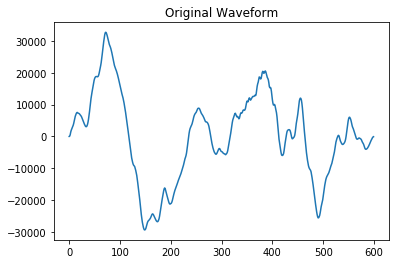

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import scipy as sp
import scipy.signal

spf = wave.open('AKWF_waveforms/AKWF_cello_0001.wav','r')
#Extract Raw Audio from Wav File
#If Stereo
if spf.getnchannels() == 2:
    print('Just mono files')
    sys.exit(0)
signal = spf.readframes(-1)
signal = np.fromstring(signal, 'Int16')

plt.figure(1)
plt.title('Original Waveform')
plt.plot(signal)
plt.show()

In [3]:
notes_to_frequencies = {'B3': 246.9417,
                        'C4': 261.6256,
                        'D4_FLAT': 277.1826, 
                        'D4': 293.6648,
                        'E4_FLAT': 311.1270,
                        'E4': 329.6276,
                        'F4': 349.2282,
                        'G4_FLAT': 369.9944,
                        'G4': 391.9954,
                        'A4_FLAT': 415.3047,
                        'A4': 440.0000,
                        'B4_FLAT': 466.1638,
                        'B4': 493.8833,
                        'C5': 523.2511,
                        'D5_FLAT': 554.3653,
                        'D5': 587.3295,
                        'E5_FLAT': 622.2540,
                        'E5': 659.2551,
                        'F5': 698.4565,
                        'G5_FLAT': 739.9888,
                        'G5': 783.9909,
                        'A5_FLAT': 830.6094,
                        'A5': 880.0000,
                        'B5_FLAT': 932.3275,
                        'B5': 987.7666,
                        'C6': 1046.502
                       }

In [4]:
def num_samples_required(lrck_f, target_f):
    return int(lrck_f/target_f + 0.5)

In [58]:
def list_candidate_frequencies(max_samples, min_samples, max_lrck):
    print('%-14s %-12s %-14s %-12s %-12s' % ('MCK (Hz)', 'RATIO', 'LRCK (Hz)', 'C6 length', 'B3 length'))
    clk = 32 * 10**6
    for mck in [clk/2, clk/3, clk/4, clk/5, clk/6, clk/8, clk/10, clk/11, clk/15, clk/16, clk/21, clk/23, clk/31, clk/42, clk/63, clk/125]:
        for ratio in [32, 48, 64, 96, 128, 192, 256, 384, 512]:
            lrck = mck/ratio
            if lrck <= max_lrck:
                min_n = (num_samples_required(lrck, notes_to_frequencies['C6']))
                max_n = (num_samples_required(lrck, notes_to_frequencies['B3']))
                if min_n >= min_samples and max_n <= max_samples:
                    print('%-14.2f %-12d %-14.2f %-12d %-12d' % (mck, ratio, mck/ratio, min_n, max_n))

list_candidate_frequencies(len(signal), 10, 96000)

MCK (Hz)       RATIO        LRCK (Hz)      C6 length    B3 length   
16000000.00    192          83333.33       80           337         
16000000.00    256          62500.00       60           253         
16000000.00    384          41666.67       40           169         
16000000.00    512          31250.00       30           127         
10666666.67    128          83333.33       80           337         
10666666.67    192          55555.56       53           225         
10666666.67    256          41666.67       40           169         
10666666.67    384          27777.78       27           112         
10666666.67    512          20833.33       20           84          
8000000.00     96           83333.33       80           337         
8000000.00     128          62500.00       60           253         
8000000.00     192          41666.67       40           169         
8000000.00     256          31250.00       30           127         
8000000.00     384          20833.

In [6]:
def generate_note_array(note, waveform, i2s_clock_frequency_hz):
    n = num_samples_required(i2s_clock_frequency_hz, notes_to_frequencies[note])
    new_signal = sp.signal.resample(waveform, n)
    return [int(x/2) for x in new_signal]

In [7]:
def initializer_list_for_c(signal):
    result = []
    result.append('{')
    for x in signal[:-1]:
        result.append(str(x))
        result.append(', ')
    result.append(str(signal[-1]))
    result.append('}')
    return ''.join(result)

def generate_soundboard_header_file(waveform, lrck_hz):
    soundboard_header_file = '''#define B3_LENGTH {}
#define C4_LENGTH {}
#define D4_FLAT_LENGTH {}
#define D4_LENGTH {}
#define E4_FLAT_LENGTH {}
#define E4_LENGTH {}
#define F4_LENGTH {}
#define G4_FLAT_LENGTH {}
#define G4_LENGTH {}
#define A4_FLAT_LENGTH {}
#define A4_LENGTH {}
#define B4_FLAT_LENGTH {}
#define B4_LENGTH {}
#define C5_LENGTH {}
#define D5_FLAT_LENGTH {}
#define D5_LENGTH {}
#define E5_FLAT_LENGTH {}
#define E5_LENGTH {}
#define F5_LENGTH {}
#define G5_FLAT_LENGTH {}
#define G5_LENGTH {}
#define A5_FLAT_LENGTH {}
#define A5_LENGTH {}
#define B5_FLAT_LENGTH {}
#define B5_LENGTH {}
#define C6_LENGTH {}
#define NO_NOTE_LENGTH 2

static int16_t B3_array[B3_LENGTH] = {};
static int16_t C4_array[C4_LENGTH] = {};
static int16_t D4_FLAT_array[D4_FLAT_LENGTH] = {};
static int16_t D4_array[D4_LENGTH] = {};
static int16_t E4_FLAT_array[E4_FLAT_LENGTH] = {};
static int16_t E4_array[E4_LENGTH] = {};
static int16_t F4_array[F4_LENGTH] = {};
static int16_t G4_FLAT_array[G4_FLAT_LENGTH] = {};
static int16_t G4_array[G4_LENGTH] = {};
static int16_t A4_FLAT_array[A4_FLAT_LENGTH] = {};
static int16_t A4_array[A4_LENGTH] = {};
static int16_t B4_FLAT_array[B4_FLAT_LENGTH] = {};
static int16_t B4_array[B4_LENGTH] = {};
static int16_t C5_array[C5_LENGTH] = {};
static int16_t D5_FLAT_array[D5_FLAT_LENGTH] = {};
static int16_t D5_array[D5_LENGTH] = {};
static int16_t E5_FLAT_array[E5_FLAT_LENGTH] = {};
static int16_t E5_array[E5_LENGTH] = {};
static int16_t F5_array[F5_LENGTH] = {};
static int16_t G5_FLAT_array[G5_FLAT_LENGTH] = {};
static int16_t G5_array[G5_LENGTH] = {};
static int16_t A5_FLAT_array[A5_FLAT_LENGTH] = {};
static int16_t A5_array[A5_LENGTH] = {};
static int16_t B5_FLAT_array[B5_FLAT_LENGTH] = {};
static int16_t B5_array[B5_LENGTH] = {};
static int16_t C6_array[C6_LENGTH] = {};
static int16_t NO_NOTE_array[NO_NOTE_LENGTH] = {{0, 0}};
'''
    
    lengths = []
    waves = []
    
    for note in notes_to_frequencies:
        new_signal = generate_note_array(note, waveform, lrck_hz)
        lengths.append(str(len(new_signal)))
        waves.append(initializer_list_for_c(new_signal))
    
    values = lengths + waves
    return soundboard_header_file.format(*values)

In [8]:
s = generate_soundboard_header_file(signal, 90909.1)
# f = open('software/apps/happy_hands/cello.h', 'w')
# f.write(s)
# f.close()

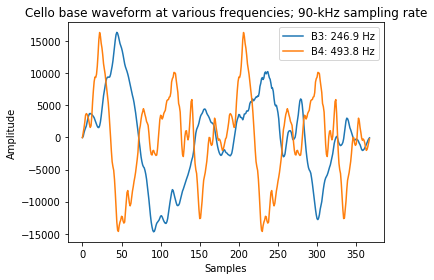

In [39]:
b3 = generate_note_array('B3', signal, 90909.1)
b4 = generate_note_array('B4', signal, 90909.1)
b5 = generate_note_array('B5', signal, 90909.1)
plt.plot(b3, label='B3: 246.9 Hz')
plt.plot(b4*2, label='B4: 493.8 Hz')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Cello base waveform at various frequencies; 90-kHz sampling rate')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('test.pdf')

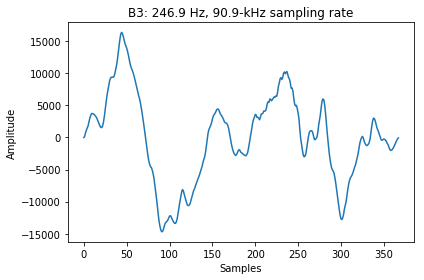

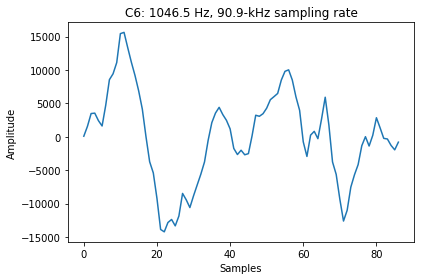

In [46]:
b3 = generate_note_array('B3', signal, 90909.1)
c6 = generate_note_array('C6', signal, 90909.1)

plt.plot(b3)
plt.title('B3: 246.9 Hz, 90.9-kHz sampling rate')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.savefig('b3.pdf')
plt.show()

plt.plot(c6)
plt.title('C6: 1046.5 Hz, 90.9-kHz sampling rate')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.savefig('c6.pdf')

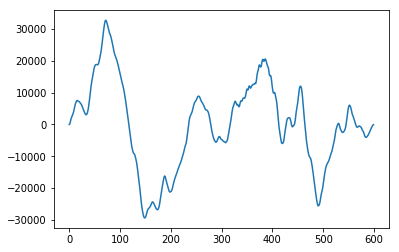

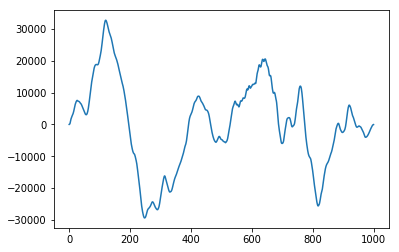

In [51]:
plt.plot(signal)
plt.show()
ns = sp.signal.resample(signal, 1000)
plt.plot(ns)
plt.show()